<a href="https://colab.research.google.com/github/TanNicholas80/Forecast_Telkomsel_Stock/blob/main/Forecasting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Forecasting/TLKM_JK.csv',parse_dates=["Date"],index_col=[0])
data = data.drop("Volume", axis=1)
data = data.drop("Adj Close", axis=1)
data.sample(10)

,Open,High,Low,Close
Date,,,,
2023-10-12,3820.0,3870.0,3800.0,3830.0
2023-05-09,4050.0,4090.0,4030.0,4070.0
2023-05-02,4210.0,4220.0,4130.0,4190.0
2023-05-04,4170.0,4190.0,4140.0,4150.0
2022-01-10,4180.0,4190.0,4100.0,4100.0
2021-12-03,4130.0,4180.0,4050.0,4070.0
2022-10-18,4310.0,4340.0,4250.0,4250.0
2023-01-10,3810.0,3850.0,3750.0,3830.0
2022-09-02,4540.0,4620.0,4540.0,4600.0


In [5]:
data.tail()

,Open,High,Low,Close
Date,,,,
2023-11-07,3600.0,3610.0,3550.0,3570.0
2023-11-08,3520.0,3540.0,3500.0,3520.0
2023-11-09,3500.0,3570.0,3500.0,3530.0
2023-11-10,3520.0,3550.0,3490.0,3550.0
2023-11-13,3570.0,3570.0,3510.0,3520.0


In [6]:
test_split=round(len(data)*0.20)
test_split

97

In [7]:
train_data = data[:-97]
test_data = data[-97:]


print(train_data.shape)
print(test_data.shape)

(390, 4)
(97, 4)


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train_data)
scaled_testing = scaler.fit_transform(test_data)

print(scaled_training.shape)
print(scaled_testing.shape)

(390, 4)
(97, 4)


In [9]:
scaled_training

array([[0.00793651, 0.00826446, 0.02608696, 0.        ],
       [0.        , 0.03305785, 0.0173913 , 0.05982906],
       [0.07936508, 0.04132231, 0.02608696, 0.02564103],
       ...,
       [0.29365079, 0.2892562 , 0.33043478, 0.30769231],
       [0.30952381, 0.2892562 , 0.33043478, 0.33333333],
       [0.3015873 , 0.28099174, 0.33043478, 0.32478632]])

In [10]:
scaled_testing

array([[0.92063492, 0.9245283 , 0.91666667, 0.89655172],
       [0.85714286, 0.86792453, 0.91666667, 0.9137931 ],
       [0.85714286, 0.9245283 , 0.91666667, 0.98275862],
       [1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.96666667, 1.        ],
       [0.95238095, 0.96226415, 0.96666667, 0.94827586],
       [0.9047619 , 0.90566038, 0.93333333, 0.96551724],
       [0.9047619 , 0.9245283 , 0.95      , 0.93103448],
       [0.88888889, 0.90566038, 0.93333333, 0.93103448],
       [0.88888889, 0.90566038, 0.91666667, 0.9137931 ],
       [0.87301587, 0.9245283 , 0.93333333, 0.96551724],
       [0.92063492, 0.96226415, 0.96666667, 0.96551724],
       [0.88888889, 0.88679245, 0.86666667, 0.86206897],
       [0.88888889, 0.86792453, 0.88333333, 0.87931034],
       [0.87301587, 0.88679245, 0.86666667, 0.84482759],
       [0.84126984, 0.81132075, 0.71666667, 0.74137931],
       [0.66666667, 0.67924528, 0.7       , 0.74137931],
       [0.6984127 , 0.69811321,

In [11]:
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        # Extract input features (Open, High, Low, Close)
        input_features = dataset[i - n_past:i, :]

        # Extract the target variable (Close price)
        target = dataset[i, 3]  # Assuming Close is in the fourth column (index 3)

        dataX.append(input_features)
        dataY.append(target)
    return np.array(dataX), np.array(dataY)

In [12]:
trainX,trainY=createXY(scaled_training,40)
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (350, 40, 4)
trainY Shape--  (350,)


In [13]:
testX,testY=createXY(scaled_testing,40)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (57, 40, 4)
testY Shape--  (57,)


In [15]:
!pip install --upgrade tensorflow keras

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import numpy as np

# Define the LSTM model
def create_lstm_model(units=50, input_shape=(trainX.shape[1], trainX.shape[2])):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define a custom wrapper class for the Keras model
class KerasRegressor(BaseEstimator):
    def __init__(self, units=50, batch_size=32, epochs=10):
        self.units = units
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_lstm_model(units=self.units)
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Create the model
model = KerasRegressor()

# Define hyperparameters for grid search
param_grid = {
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

# Fit the grid search to your training data
grid_search.fit(trainX, trainY)

# Print the best parameters and their corresponding MSE
print("Best Parameters: ", grid_search.best_params_)
print("Best MSE: ", -grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(testX)
test_mse = mean_squared_error(testY, test_predictions)
print("Test MSE for the best model: ", test_mse)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters:  {'batch_size': 32, 'epochs': 30, 'units': 150}
Best MSE:  0.006196431834827712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Test MSE for the best model:  0.010401466478163455


In [14]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import numpy as np
import keras_tuner as kt
import tensorflow as tf

def build_hypermodel(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50),
                   input_shape=(trainX.shape[1], trainX.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

tuner = kt.RandomSearch(build_hypermodel,
                     objective='val_loss',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='tuning_dir',
                     project_name='lstm_tuning')

tuner.search(trainX, trainY, epochs=30, validation_split=0.2,)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(trainX, trainY, epochs=30, validation_split=0.2)

# val_acc_per_epoch = history.history['val_loss']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

Reloading Tuner from tuning_dir/lstm_tuning/tuner0.json
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1223 - val_loss: 0.0210
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0302 - val_loss: 0.0063
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0058
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - val_loss: 0.0056
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 12/30
9/9 ━━━━━━━━━━━━━

In [30]:
# Evaluate the best model on the test data
test_predictions = best_model.predict(testX)
test_mse = mean_squared_error(testY, test_predictions)
print("Test MSE for the best model: ", test_mse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MSE for the best model:  0.011070248260275752


In [17]:
# hypermodel = tuner.hypermodel.build(best_hps)

# hypermodel.fit(trainX, trainY, epochs=best_epoch, validation_split=0.2)

# test_predictions = hypermodel.predict(testX)
# test_mse = mean_squared_error(testY, test_predictions)
# print("Test MSE for the best model: ", test_mse)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1996 - val_loss: 0.0284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Test MSE for the best model:  0.06398021404966353


In [31]:
print("prediction\n", test_predictions)
print("\nPrediction Shape-",test_predictions.shape)

prediction
 [[0.5816965 ]
 [0.5661729 ]
 [0.5400697 ]
 [0.52592635]
 [0.5120383 ]
 [0.5500967 ]
 [0.55835927]
 [0.5405063 ]
 [0.5349782 ]
 [0.53329927]
 [0.5602012 ]
 [0.56880134]
 [0.5499696 ]
 [0.52437115]
 [0.5178063 ]
 [0.504033  ]
 [0.49221244]
 [0.49783596]
 [0.48513255]
 [0.4909602 ]
 [0.5429559 ]
 [0.590167  ]
 [0.64557374]
 [0.64770234]
 [0.63716453]
 [0.6121315 ]
 [0.6043824 ]
 [0.5941699 ]
 [0.59630007]
 [0.60341096]
 [0.5947178 ]
 [0.6085468 ]
 [0.6028148 ]
 [0.62133604]
 [0.62635934]
 [0.66003704]
 [0.67983985]
 [0.6696692 ]
 [0.66017455]
 [0.6306568 ]
 [0.5985898 ]
 [0.55912167]
 [0.50206953]
 [0.45255846]
 [0.41017005]
 [0.3251756 ]
 [0.24494594]
 [0.1688269 ]
 [0.12153784]
 [0.18947686]
 [0.24880978]
 [0.25215796]
 [0.28466943]
 [0.2795736 ]
 [0.24286036]
 [0.223619  ]
 [0.20875333]]

Prediction Shape- (57, 1)


In [32]:
prediction_copies_array = np.repeat(test_predictions,4, axis=-1)
prediction_copies_array.shape

(57, 4)

In [33]:
prediction_copies_array

array([[0.5816965 , 0.5816965 , 0.5816965 , 0.5816965 ],
       [0.5661729 , 0.5661729 , 0.5661729 , 0.5661729 ],
       [0.5400697 , 0.5400697 , 0.5400697 , 0.5400697 ],
       [0.52592635, 0.52592635, 0.52592635, 0.52592635],
       [0.5120383 , 0.5120383 , 0.5120383 , 0.5120383 ],
       [0.5500967 , 0.5500967 , 0.5500967 , 0.5500967 ],
       [0.55835927, 0.55835927, 0.55835927, 0.55835927],
       [0.5405063 , 0.5405063 , 0.5405063 , 0.5405063 ],
       [0.5349782 , 0.5349782 , 0.5349782 , 0.5349782 ],
       [0.53329927, 0.53329927, 0.53329927, 0.53329927],
       [0.5602012 , 0.5602012 , 0.5602012 , 0.5602012 ],
       [0.56880134, 0.56880134, 0.56880134, 0.56880134],
       [0.5499696 , 0.5499696 , 0.5499696 , 0.5499696 ],
       [0.52437115, 0.52437115, 0.52437115, 0.52437115],
       [0.5178063 , 0.5178063 , 0.5178063 , 0.5178063 ],
       [0.504033  , 0.504033  , 0.504033  , 0.504033  ],
       [0.49221244, 0.49221244, 0.49221244, 0.49221244],
       [0.49783596, 0.49783596,

In [34]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(test_predictions),4)))[:,0]
pred

array([3766.4688, 3756.689 , 3740.244 , 3731.3337, 3722.584 , 3746.561 ,
       3751.766 , 3740.519 , 3737.0364, 3735.9785, 3752.9268, 3758.3447,
       3746.481 , 3730.3538, 3726.218 , 3717.5408, 3710.0938, 3713.6367,
       3705.6335, 3709.305 , 3742.0623, 3771.8052, 3806.7114, 3808.0522,
       3801.4136, 3785.6428, 3780.761 , 3774.3271, 3775.669 , 3780.149 ,
       3774.6724, 3783.3843, 3779.7732, 3791.4417, 3794.6064, 3815.8232,
       3828.2993, 3821.8916, 3815.9102, 3797.3137, 3777.1116, 3752.2466,
       3716.3037, 3685.1118, 3658.407 , 3604.8606, 3554.316 , 3506.361 ,
       3476.569 , 3519.3704, 3556.7502, 3558.8596, 3579.3416, 3576.131 ,
       3553.002 , 3540.88  , 3531.5146], dtype=float32)

In [35]:
original_copies_array = np.repeat(testY,4, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),4)))[:,0]

In [36]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [3766.4688 3756.689  3740.244  3731.3337 3722.584  3746.561  3751.766
 3740.519  3737.0364 3735.9785 3752.9268 3758.3447 3746.481  3730.3538
 3726.218  3717.5408 3710.0938 3713.6367 3705.6335 3709.305  3742.0623
 3771.8052 3806.7114 3808.0522 3801.4136 3785.6428 3780.761  3774.3271
 3775.669  3780.149  3774.6724 3783.3843 3779.7732 3791.4417 3794.6064
 3815.8232 3828.2993 3821.8916 3815.9102 3797.3137 3777.1116 3752.2466
 3716.3037 3685.1118 3658.407  3604.8606 3554.316  3506.361  3476.569
 3519.3704 3556.7502 3558.8596 3579.3416 3576.131  3553.002  3540.88
 3531.5146]

Original Values--  [3725.86206897 3725.86206897 3704.13793103 3725.86206897 3823.62068966
 3736.72413793 3725.86206897 3736.72413793 3747.5862069  3801.89655172
 3769.31034483 3693.27586207 3704.13793103 3715.         3715.
 3682.4137931  3725.86206897 3682.4137931  3736.72413793 3823.62068966
 3823.62068966 3877.93103448 3780.17241379 3769.31034483 3725.86206897
 3758.44827586 3758.44827586 3780.17241379

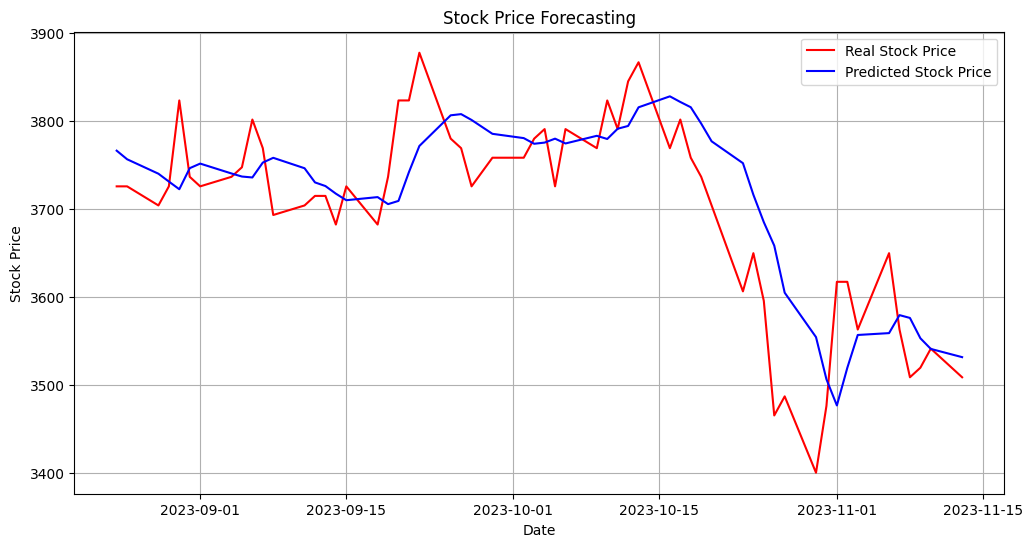

In [37]:
import matplotlib.pyplot as plt

# Plot the range by date
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(original):], original, color='red', label='Real Stock Price')
plt.plot(data.index[-len(pred):], pred, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# 30 Day Dataset Generated By LSTM

In [33]:
def extend_dataset_with_future(dataset, n_future):
    extended_dataset = np.copy(dataset)

    for i in range(1, n_future + 1):
        # Tambahkan data baru untuk setiap hari ke depan
        new_data_point = dataset[-i, :]  # Menggunakan data terakhir sebagai referensi
        extended_dataset = np.vstack([extended_dataset, new_data_point])

    return extended_dataset

In [34]:
extended_train = extend_dataset_with_future(scaled_training, 31)
trainnX,trainnY=createXY(extended_train, 40)
print("trainX Shape-- ",trainnX.shape)
print("trainY Shape-- ",trainnY.shape)

trainX Shape--  (381, 40, 4)
trainY Shape--  (381,)


In [35]:
extended_train = extend_dataset_with_future(scaled_testing, 31)
testsX,testsY=createXY(extended_train,40)
print("testX Shape-- ",testsX.shape)
print("testY Shape-- ",testsY.shape)

testX Shape--  (88, 40, 4)
testY Shape--  (88,)


In [36]:
# Define the LSTM model
def create_lstm_model(units=50, input_shape=(trainnX.shape[1], trainnX.shape[2])):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define a custom wrapper class for the Keras model
class KerasRegressor(BaseEstimator):
    def __init__(self, units=50, batch_size=32, epochs=10):
        self.units = units
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_lstm_model(units=self.units)
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Create the model
model = KerasRegressor()

# Define hyperparameters for grid search
param_grid = {
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

# Fit the grid search to your training data
grid_search.fit(trainnX, trainnY)

# Print the best parameters and their corresponding MSE
print("Best Parameters: ", grid_search.best_params_)
print("Best MSE: ", -grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_prediction = best_model.predict(testsX)
test_mse = mean_squared_error(testsY, test_prediction)
print("Test MSE for the best model: ", test_mse)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
print("prediction\n", test_prediction)
print("\nPrediction Shape-",test_prediction.shape)

In [ ]:
prediction_copy_array = np.repeat(test_prediction,4, axis=-1)
prediction_copy_array.shape

prediction_copy_array

In [ ]:
predict=scaler.inverse_transform(np.reshape(prediction_copy_array,(len(test_prediction),4)))[:,0]
predict

In [ ]:
n_future = 31
predicted_dates = pd.date_range(start=data.index[-1], periods=n_future + 1, freq='B')[1:]
predicted_data = pd.DataFrame(index=predicted_dates, columns=['Predicted_Close'])
predicted_data['Predicted_Close'] = predict[-n_future:].flatten()

In [ ]:
print(predicted_data)

In [ ]:
# Plot the range by date
plt.figure(figsize=(12, 6))
plt.plot(predicted_data.index[-len(predicted_data):], predicted_data, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# import plotly.graph_objects as go

# # Assuming 'data' is your original stock price data
# # 'predicted_data' should contain OHLC (Open, High, Low, Close) data for candlesticks

# # Assuming your candlestick plot should have the same date range as the predicted data


# # Create a candlestick chart
# fig = go.Figure(data=[go.Candlestick(x=predicted_data.index,
#                                      close=predicted_data['Predicted_Close'])])

# # Customize the layout
# fig.update_layout(title='Stock Price Forecasting - Candlestick Chart',
#                   xaxis_title='Date',
#                   yaxis_title='Stock Price',
#                   xaxis_rangeslider_visible=False,
#                   width=1200,  # Set the width of the figure
#                   height=600)  # Set the height of the figure

# # Show the plot
# fig.show()

In [ ]:
import plotly.graph_objects as go

# Assuming 'data' is your original stock price data
# Assuming your candlestick plot should have the same date range as the predicted data
# Create a candlestick chart for Close prices
fig = go.Figure(data=[go.Candlestick(x=predicted_data.index,
                                     open=predicted_data['Predicted_Close'],
                                     high=predicted_data['Predicted_Close'],
                                     low=predicted_data['Predicted_Close'],
                                     close=predicted_data['Predicted_Close'],
                                     name='Predicted Close Prices')])

# Customize the layout
fig.update_layout(title='Stock Price Forecasting - Candlestick Chart (Close Prices Only)',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  xaxis_rangeslider_visible=False,
                  width=1200,
                  height=600)

# Show the plot
fig.show()

In [ ]:
# def create_dataset(dataset, n_past=100, n_future=31):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - n_past - n_future + 1):
#         a = dataset[i:(i + n_past), 0]  # Sesuaikan indeks kolom sesuai dengan data Anda
#         b = dataset[(i + n_past):(i + n_past + n_future), 0]  # Sesuaikan indeks kolom sesuai dengan data Anda
#         dataX.append(a)
#         dataY.append(b)
#     return np.array(dataX), np.array(dataY)

# # Fungsi untuk membuat model LSTM
# def create_lstm_model(n_past, n_features):
#     model = Sequential()
#     model.add(LSTM(50, input_shape=(n_past, n_features), return_sequences=True))
#     model.add(LSTM(50, return_sequences=False))
#     model.add(Dense(31))  # Sesuaikan dengan jumlah langkah waktu ke depan
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Baca data harga saham
# # Gantilah 'your_stock_data.csv' dengan nama file CSV yang sesuai dengan data Anda
# dataseter = pd.read_csv('/content/drive/MyDrive/Forecasting/BMRI_JK.csv')
# prices = dataseter['Close'].values.reshape(-1, 1)  # Sesuaikan dengan nama kolom harga saham di data Anda

# # Normalisasi data ke dalam rentang 0-1
# scaler = MinMaxScaler(feature_range=(0, 1))
# prices_scaled = scaler.fit_transform(prices)

# # Membuat dataset (X, Y) untuk pelatihan
# trainX, trainY = create_dataset(prices_scaled)

# # Reshape input untuk sesuai dengan format yang diterima oleh LSTM
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# # Membuat dan melatih model LSTM
# model = create_lstm_model(n_past=100, n_features=1)  # Sesuaikan dengan panjang masa lalu dan jumlah fitur
# model.fit(trainX, trainY, epochs=50, batch_size=32)

# # Prediksi untuk 31 hari ke depan
# future_steps = 31
# last_100_days = prices_scaled[-100:]
# input_sequence = last_100_days.reshape((1, 100, 1))  # Sesuaikan dengan panjang masa lalu dan jumlah fitur

In [ ]:
# predicted_prices_scaled = []
# for _ in range(future_steps):
#     predicted_price_scaled = model.predict(input_sequence)
#     predicted_prices_scaled.append(predicted_price_scaled.flatten())
#     input_sequence = np.append(input_sequence[:, 1:, :], predicted_price_scaled.reshape((1, 31, 1)), axis=1)

# # Invers normalisasi prediksi
# predicted_prices = scaler.inverse_transform(np.array(predicted_prices_scaled).reshape(-1, 1))

# # Tampilkan hasil prediksi
# predicted_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='B')[1:]
# predicted_data = pd.DataFrame(index=predicted_dates, columns=['Predicted_Close'])
# predicted_data['Predicted_Close'] = predicted_prices[:future_steps].flatten()

In [ ]:
# print(predicted_data)

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(predicted_data, color='blue', label='Predicted 31 Days')
# plt.title('Stock Price Forecasting 31 Days Later')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming 'predicted_data' is your DataFrame with predicted data
# Assuming your candlestick plot should have the same date range as the predicted data



# Create a candlestick chart for Close prices with vertical orientation
fig = go.Figure(data=[go.Candlestick(x=predicted_data.index,
                                     open=predicted_data['Predicted_Close'],
                                     high=predicted_data['Predicted_Close'],
                                     low=predicted_data['Predicted_Close'],
                                     close=predicted_data['Predicted_Close'],
                                     name='Predicted Close Prices')])

# Customize the layout
fig.update_layout(title='Stock Price Forecasting - Vertical Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  xaxis_rangeslider_visible=False,
                  width=1200,
                  height=600)

# Show the plot
fig.show()
